In [1]:
# Core Imports and Global Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from PIL import Image # Required for Gradio and some visualization utilities

# Import Weights & Biases
import wandb
import os # For environment variables, useful for W&B

# Import Gradio (install if not present in Kaggle environment)
try:
    import gradio as gr
except ImportError:
    !pip install gradio --quiet
    import gradio as gr
print("Installation Complete")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 106.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 3.6 MB/s eta 0:00:00
Installation Complete


In [2]:
# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# --- Global Hyperparameters and Configuration ---
# Define hyperparameters in a dictionary, which is good for W&B logging.
config = {
    "project_name": "MNIST-CNN-Full-Project",
    "learning_rate": 0.001,
    "epochs": 10,
    "batch_size": 64,
    "optimizer": "Adam",
    "loss_function": "CrossEntropyLoss",
    "model_architecture": "DigitCNN",
    "dropout_rate": 0.5,
    "seed": 42, # For reproducibility
    "noise_levels_to_test": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0],
    "model_save_path": "mnist_cnn.pt" # Consistent path for saving/loading model
}

In [4]:
# Retrieve Secrets
from kaggle_secrets import UserSecretsClient
import os # Import the os module to set environment variables
import wandb # Import wandb

user_secrets = UserSecretsClient()

# Retrieve your Hugging Face token (if needed later for pushing to Hugging Face Hub)
secret_value_0 = user_secrets.get_secret("Hugging faces")

# Retrieve your Weights & Biases API key
secret_value_1 = user_secrets.get_secret("wandb_api_key")

# --- CRITICAL STEP FOR W&B ---
# Set the retrieved secret as an environment variable that wandb.login() will automatically find
os.environ["WANDB_API_KEY"] = secret_value_1
print("WANDB_API_KEY environment variable set from Kaggle Secrets.")


# Cell 2: W&B Login and Init (this part should now be fast)
print("\n--- Initializing Weights & Biases Run ---")
wandb.login()
wandb.init(project=config["project_name"], config=config) # Use config["project_name"] for consistency
print(f"W&B run initialized. Project: {wandb.run.project}, Run ID: {wandb.run.id}")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


WANDB_API_KEY environment variable set from Kaggle Secrets.

--- Initializing Weights & Biases Run ---


wandb: Currently logged in as: vinodanbalagan (vinodanbalagan-university-of-toronto) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250615_184001-cdaoz300
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ancient-lion-2
wandb: ⭐️ View project at https://wandb.ai/vinodanbalagan-university-of-toronto/MNIST-CNN-Full-Project
wandb: 🚀 View run at https://wandb.ai/vinodanbalagan-university-of-toronto/MNIST-CNN-Full-Project/runs/cdaoz300


W&B run initialized. Project: MNIST-CNN-Full-Project, Run ID: cdaoz300


In [5]:
# Set random seed for reproducibility
torch.manual_seed(config["seed"])
np.random.seed(config["seed"]) # For numpy-related operations if any

In [6]:
# Model Definition (from mnist_pytorch_model.py)
class DigitCNN(nn.Module):
    """
    A simple Convolutional Neural Network (CNN) designed for the MNIST digit classification task.
    This model consists of two convolutional layers followed by max-pooling, a dropout layer,
    and a final fully connected layer for classification.
    """
    def __init__(self):
        super(DigitCNN, self).__init__()
        # Conv1: 1 input channel (grayscale), 32 output channels, 3x3 kernel
        self.conv1 = nn.Conv2d(1, 32, 3)
        # Conv2: 32 input channels (from conv1), 64 output channels, 3x3 kernel
        self.conv2 = nn.Conv2d(32, 64, 3)
        # Dropout layer to prevent overfitting. `p` is the probability of an element being zeroed.
        self.dropout = nn.Dropout(config["dropout_rate"])
        # Fully Connected Layer: Input features calculated from flattened conv output, 10 output classes
        # After two conv layers and two 2x2 max-pools on a 28x28 image:
        # 28x28 -> (conv1, 3x3) -> 26x26 -> (max_pool2d, 2x2) -> 13x13
        # 13x13 -> (conv2, 3x3) -> 11x11 -> (max_pool2d, 2x2) -> 5x5
        # So, the final feature map size is 64 channels * 5 * 5 = 1600 features
        self.fc = nn.Linear(64 * 5 * 5, 10)

    def forward(self, x):
        # Apply conv1, then ReLU activation, then 2x2 max pooling
        x = F.relu(self.conv1(x)) # Output shape: (batch, 32, 26, 26)
        x = F.max_pool2d(x, 2)    # Output shape: (batch, 32, 13, 13)
        # Apply conv2, then ReLU activation, then 2x2 max pooling
        x = F.relu(self.conv2(x)) # Output shape: (batch, 64, 11, 11)
        x = F.max_pool2d(x, 2)    # Output shape: (batch, 64, 5, 5)
        # Flatten the tensor for the fully connected layer
        x = x.view(-1, 64 * 5 * 5) # Output shape: (batch, 1600)
        # Apply dropout for regularization
        x = self.dropout(x)
        # Apply the final fully connected layer to get logits
        x = self.fc(x)            # Output shape: (batch, 10)
        return x

In [7]:
# Utility Function: Add Noise (from test_noise.py, adapted)
def add_noise(img_tensor: torch.Tensor, noise_level: float = 0.3) -> torch.Tensor:
    """
    Adds Gaussian noise to an image tensor.
    Important: The normalization transform (mean=0.1307, std=0.3081) on MNIST
    data means values can go outside [0,1]. Clipping should be adjusted
    to the expected range of normalized data. For MNIST, typically around [-0.4, 3.0].
    Clipping to this broader range is safer than [0,1] for normalized data.
    """
    noise = noise_level * torch.randn_like(img_tensor)
    # Clip values to prevent extreme outliers while respecting normalized range
    # MNIST normalized values generally range from ~-0.42 to ~3.0
    return torch.clip(img_tensor + noise, -0.5, 3.5) # Example adjusted clip range

In [8]:
# Data Preparation (from train_model.py & test_noise.py)
print("\n--- Data Preparation ---")
# Transformation pipeline for MNIST images
# ToTensor converts PIL Image or numpy.ndarray (H x W x C) to a FloatTensor of shape (C x H x W)
# and scales pixel intensity values from [0, 255] to [0.0, 1.0].
# Normalize standardizes the tensor using the pre-calculated mean and std dev for MNIST.
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the full MNIST training dataset
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=data_transform)

# Split the training dataset into training and validation sets
# Using a generator with a manual seed for reproducible splits
train_set, val_set = random_split(
    full_train_dataset, [54000, 6000],
    generator=torch.Generator().manual_seed(config["seed"])
)

# Create DataLoaders for batching and shuffling
train_loader = DataLoader(train_set, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_set, batch_size=config["batch_size"])

# Load the MNIST test dataset (for final evaluation and noise testing)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=data_transform)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"])

print(f"Train samples: {len(train_set)}, Validation samples: {len(val_set)}, Test samples: {len(test_dataset)}")
print("Data loaded and prepared.")


--- Data Preparation ---


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.05MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 148kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.40MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.96MB/s]

Train samples: 54000, Validation samples: 6000, Test samples: 10000
Data loaded and prepared.


In [9]:
# Training & Validation Function (from train_model.py, with W&B logging)
def train_and_validate(model, train_loader, val_loader, optimizer, num_epochs, device):
    print("\n--- Starting Training ---")
    # Lists to store metrics for plotting
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # --- Training Loop ---
        model.train() # Set model to training mode (enables dropout, etc.)
        running_train_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device) # Move data to appropriate device

            optimizer.zero_grad() # Clear previous gradients
            output = model(data)  # Forward pass: get model predictions (logits)
            loss = F.cross_entropy(output, target) # Calculate loss
            loss.backward()       # Backward pass: compute gradients
            optimizer.step()      # Update model parameters

            running_train_loss += loss.item() * data.size(0) # Accumulate batch loss

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # --- Validation Loop ---
        model.eval() # Set model to evaluation mode (disables dropout, etc.)
        val_correct = 0
        val_total = 0
        running_val_loss = 0.0
        with torch.no_grad(): # Disable gradient calculations for efficiency
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                running_val_loss += F.cross_entropy(output, target, reduction='sum').item() # Sum loss for whole validation set
                pred = output.argmax(dim=1) # Get predicted class (index of max log-probability)
                val_correct += pred.eq(target).sum().item() # Count correct predictions
                val_total += target.size(0) # Count total samples

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        val_accuracy = 100. * val_correct / val_total
        val_accuracies.append(val_accuracy)

        # Log metrics to console
        print(f"Epoch {epoch + 1}/{num_epochs}: "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.2f}%")

        # Log metrics to Weights & Biases
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": epoch_train_loss,
            "val_loss": epoch_val_loss,
            "val_accuracy": val_accuracy
        })
    print("Training complete.")
    return train_losses, val_losses, val_accuracies


In [10]:
# Model Training Execution
model = DigitCNN().to(device) # Instantiate model and move to device
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

# Run the training and validation process
train_losses, val_losses, val_accuracies = train_and_validate(
    model, train_loader, val_loader, optimizer, config["epochs"], device
)


--- Starting Training ---
Epoch 1/10: Train Loss: 0.2009, Val Loss: 0.0723, Val Accuracy: 97.85%
Epoch 2/10: Train Loss: 0.0792, Val Loss: 0.0522, Val Accuracy: 98.48%
Epoch 3/10: Train Loss: 0.0628, Val Loss: 0.0512, Val Accuracy: 98.45%
Epoch 4/10: Train Loss: 0.0527, Val Loss: 0.0465, Val Accuracy: 98.73%
Epoch 5/10: Train Loss: 0.0486, Val Loss: 0.0409, Val Accuracy: 98.82%
Epoch 6/10: Train Loss: 0.0451, Val Loss: 0.0405, Val Accuracy: 98.80%
Epoch 7/10: Train Loss: 0.0411, Val Loss: 0.0431, Val Accuracy: 98.82%
Epoch 8/10: Train Loss: 0.0390, Val Loss: 0.0376, Val Accuracy: 98.82%
Epoch 9/10: Train Loss: 0.0327, Val Loss: 0.0370, Val Accuracy: 98.87%
Epoch 10/10: Train Loss: 0.0342, Val Loss: 0.0419, Val Accuracy: 98.92%
Training complete.


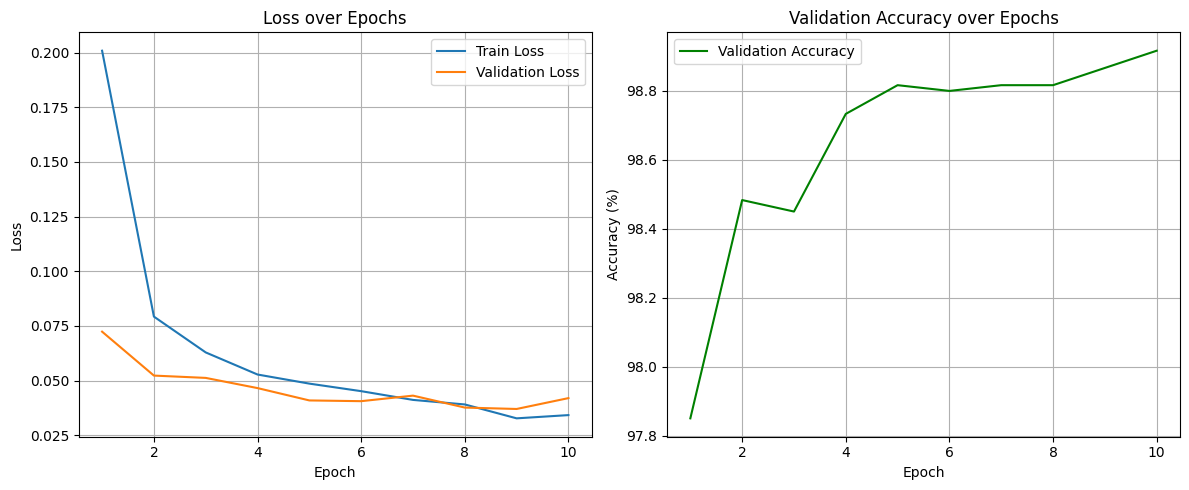

In [11]:
# Plotting Training Progress
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, config["epochs"] + 1), train_losses, label='Train Loss')
plt.plot(range(1, config["epochs"] + 1), val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, config["epochs"] + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt_path = "training_progress_plot.png"
plt.savefig(plt_path) # Save plot to file
wandb.log({"Training Progress": wandb.Image(plt_path)}) # Log plot to W&B
plt.show() # Display plot in notebook

In [12]:
# Save Trained Model
torch.save(model.state_dict(), config["model_save_path"])
print(f"Model saved to {config['model_save_path']}")
wandb.save(config["model_save_path"]) # Save model artifact to W&B
print(f"Model artifact logged to W&B.")

Model saved to mnist_cnn.pt
Model artifact logged to W&B.


In [13]:
# Evaluation with Noise Function 
def evaluate_with_noise(model, test_loader, device, noise_level):
    print(f"\n--- Evaluating with Noise (level={noise_level}) ---")
    model.eval() # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            noisy_data = add_noise(data, noise_level=noise_level) # Apply noise
            output = model(noisy_data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

    accuracy = correct / total * 100
    print(f"Accuracy with noise: {accuracy:.2f}%")
    return accuracy



--- Running Noise Robustness Test ---

--- Evaluating with Noise (level=0.0) ---
Accuracy with noise: 99.06%

--- Evaluating with Noise (level=0.1) ---
Accuracy with noise: 99.06%

--- Evaluating with Noise (level=0.2) ---
Accuracy with noise: 99.05%

--- Evaluating with Noise (level=0.3) ---
Accuracy with noise: 99.03%

--- Evaluating with Noise (level=0.4) ---
Accuracy with noise: 99.03%

--- Evaluating with Noise (level=0.5) ---
Accuracy with noise: 98.84%

--- Evaluating with Noise (level=0.7) ---
Accuracy with noise: 97.33%

--- Evaluating with Noise (level=1.0) ---
Accuracy with noise: 84.86%


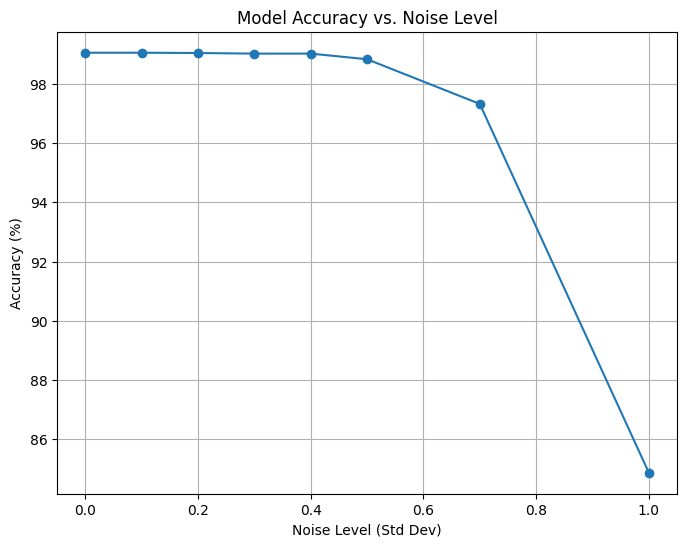

In [14]:
# Run Noise Evaluation & Plot Robustness
accuracies_with_noise = []

print("\n--- Running Noise Robustness Test ---")
for level in config["noise_levels_to_test"]:
    acc = evaluate_with_noise(model, test_loader, device, level)
    accuracies_with_noise.append(acc)
    # Log individual noise level accuracy to W&B
    wandb.log({f"accuracy_noise_level_{level:.1f}": acc})

# Plot Noise Robustness Curve
plt.figure(figsize=(8, 6))
plt.plot(config["noise_levels_to_test"], accuracies_with_noise, marker='o', linestyle='-')
plt.title('Model Accuracy vs. Noise Level')
plt.xlabel('Noise Level (Std Dev)')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt_path = "noise_robustness_plot.png"
plt.savefig(plt_path)
wandb.log({"Noise Robustness Curve": wandb.Image(plt_path)})
plt.show()



--- Generating Confusion Matrix ---


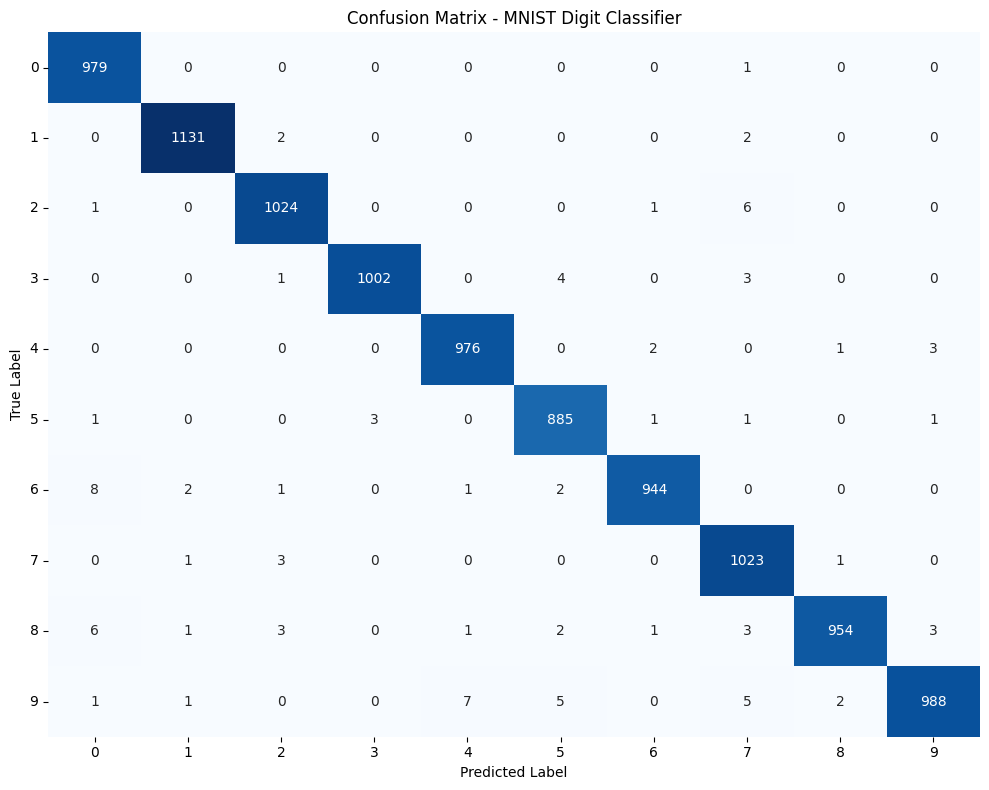


--- Visualizing Activation Maps ---
Original Input Image for Activation Map (Label: 7)


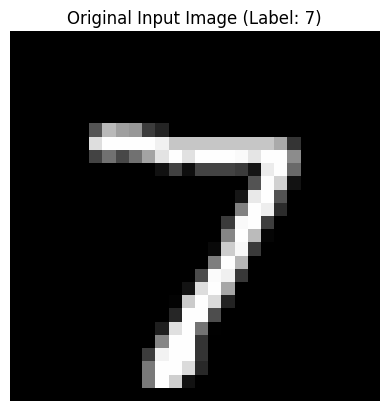

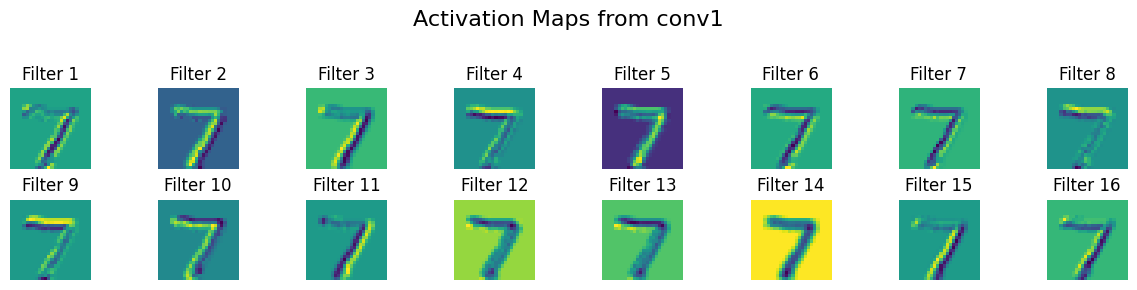

In [15]:
# Visualizations 

# Confusion Matrix
print("\n--- Generating Confusion Matrix ---")
all_preds = []
all_labels = []
with torch.no_grad():
    for imgs, labels in test_loader: # Use test_loader for final evaluation
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - MNIST Digit Classifier")
plt.xticks(np.arange(10) + 0.5, labels=range(10))
plt.yticks(np.arange(10) + 0.5, labels=range(10), rotation=0)
plt.tight_layout()
plt_path = "confusion_matrix.png"
plt.savefig(plt_path)
wandb.log({"Confusion Matrix": wandb.Image(plt_path)})
plt.show()

# Activation Maps
def visualize_feature_maps(image_tensor, model, layer_name='conv1', num_filters_to_show=16):
    """
    Visualizes the activation maps of a specific convolutional layer for an input image.
    Logs the image to W&B.
    """
    activation = {}

    def hook_fn(module, input, output):
        activation[layer_name] = output

    target_layer = None
    for name, module in model.named_modules():
        if name == layer_name:
            target_layer = module
            break
    if target_layer is None:
        print(f"Layer '{layer_name}' not found in the model.")
        return

    hook = target_layer.register_forward_hook(hook_fn)

    model.eval() # Ensure model is in eval mode for consistent forward pass
    with torch.no_grad():
        image_tensor = image_tensor.to(device) # Move input image to device
        model(image_tensor)

    act = activation[layer_name].squeeze()
    
    if act.dim() == 2: # Handle case of single feature map (e.g., if you only had 1 filter)
        fig, ax = plt.subplots(figsize=(4,4))
        ax.imshow(act.cpu(), cmap='gray')
        ax.set_title(f"{layer_name} Activation Map")
        ax.axis('off')
    else: # Multiple feature maps
        n_filters = min(act.shape[0], num_filters_to_show)
        cols = 8
        rows = (n_filters + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 1.5))
        axes = axes.flatten()

        for i in range(n_filters):
            ax = axes[i]
            ax.imshow(act[i].cpu(), cmap='viridis')
            ax.set_title(f'Filter {i+1}')
            ax.axis('off')

        for i in range(n_filters, len(axes)): # Hide unused subplots
            axes[i].axis('off')

    plt.suptitle(f"Activation Maps from {layer_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt_path = f"activation_maps_{layer_name}.png"
    plt.savefig(plt_path)
    wandb.log({f"Activation Maps ({layer_name})": wandb.Image(plt_path)})
    plt.show()

    hook.remove()

# Example Usage for Activation Maps:
print("\n--- Visualizing Activation Maps ---")
# Get a single image from the test set (already transformed and normalized)
sample_image_tensor, sample_label = test_dataset[0]
print(f"Original Input Image for Activation Map (Label: {sample_label})")

# Denormalize for display purposes if needed, otherwise the values will be non-intuitive
mean_val = 0.1307
std_val = 0.3081
display_image = (sample_image_tensor * std_val) + mean_val # Reverse normalization for display
plt.imshow(display_image.squeeze().cpu().numpy(), cmap='gray')
plt.title(f"Original Input Image (Label: {sample_label})")
plt.axis('off')
plt.show()

# Visualize for conv1 layer
visualize_feature_maps(sample_image_tensor.unsqueeze(0), model, layer_name='conv1')
# Visualize for conv2 layer (uncomment to see)
# visualize_feature_maps(sample_image_tensor.unsqueeze(0), model, layer_name='conv2')


In [16]:
# Cell 14: End W&B Run
# This is important to finalize the run and ensure all data is synced.
wandb.finish()
print("\nWeights & Biases run finished.")

wandb: uploading output.log; uploading wandb-summary.json
wandb: uploading mnist_cnn.pt
wandb: uploading summary
wandb:                                                                                
wandb: 
wandb: Run history:
wandb: accuracy_noise_level_0.0 ▁
wandb: accuracy_noise_level_0.1 ▁
wandb: accuracy_noise_level_0.2 ▁
wandb: accuracy_noise_level_0.3 ▁
wandb: accuracy_noise_level_0.4 ▁
wandb: accuracy_noise_level_0.5 ▁
wandb: accuracy_noise_level_0.7 ▁
wandb: accuracy_noise_level_1.0 ▁
wandb:                    epoch ▁▂▃▃▄▅▆▆▇█
wandb:               train_loss █▃▂▂▂▂▁▁▁▁
wandb:             val_accuracy ▁▅▅▇▇▇▇▇██
wandb:                 val_loss █▄▄▃▂▂▂▁▁▂
wandb: 
wandb: Run summary:
wandb: accuracy_noise_level_0.0 99.06
wandb: accuracy_noise_level_0.1 99.06
wandb: accuracy_noise_level_0.2 99.05
wandb: accuracy_noise_level_0.3 99.03
wandb: accuracy_noise_level_0.4 99.03
wandb: accuracy_noise_level_0.5 98.84
wandb: accuracy_noise_level_0.7 97.33
wandb: accuracy_noise_level_1.0 84


Weights & Biases run finished.
